# The Battle of Cairo's Neighborhoods 

## Introduction

Cairo is a sprawling city, and like you probably noticed in other big cities, not all neighborhoods were created equal.
The aim of this project is to use Foursquare location data to explore and compare neighborhoods of Cairo and use these data to solve a problem.


## Problem Description

If a company is trying to start their own business in Cairo, where would you recommend that they setup their office? It would depend on a lot of factors like what is the type of business? and what are the target customers? 
To help answering these questions we need to know what the most common venues in every neighborhood in Cairo are and what are the similarities and differences between these neighborhoods. 
In this project we will cluster neighborhoods based on the most common venues like Hotels, Historic sites, restaurants, or parks. Which will help any company decide where to locate their office based on the pattern of location of these venues. 


## Target Audiences

Companies or individuals who are trying to find the best neighborhood in Cairo to locate their office based on the most common venues in each neighborhood.

#### Load the needed Libraries

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


## Data description

I collected the all the neighborhoods in Cairo and their location data from Wikipedia in a CSV file. Then plugged these locations in Foursquare API to get all the venues in every neighborhood within 5 km.
Foursquare API gives a lot of information about every venue, but I only used the Category description of the venue. 


In [2]:
cairo_df = pd.read_csv('cairo.csv')
cairo_df.head()

,Neighborhood,lat,lng
0,Abbassia,30.065008,31.271710
1,Ain Shams,30.127778,31.329167
2,Azbakeya,30.052778,31.248333
3,Bulaq,30.053000,31.230000
4,Daher,30.074167,31.270000


#### Map all the neighborhoods using Folium Library

In [9]:
# create map
map_neighborhoods = folium.Map(location=[30.0444, 31.2357], zoom_start=11)

# add markers to the map
markers_colors = []
for lat, lon, poi in zip(cairo_df['lat'], cairo_df['lng'], cairo_df['Neighborhood']):
    label = folium.Popup(str(poi), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        fill=True,
        fill_opacity=0.7).add_to(map_neighborhoods)
       
map_neighborhoods

## Explore the venues of each neighborhood using Foursquare API

In [10]:
#Next, we are going to start utlizing the Foursquare API to explore the neighborhoods and segment them.
#Define Foursquare Credentials and Version
CLIENT_ID = 'HY0O3WA2ZT1WEKDLBWYWQ4YKOLLASMZDKM1HX5ZU12P2VTYD' # your Foursquare ID
CLIENT_SECRET = 'WYAQKWUNFNULKTVV1P0WVAZG3Q50V5NHRTMBQELTMI315AI5' # your Foursquare Secret
ACCESS_TOKEN = '1PEFSCZN3ALJQTG4X4VDUQGMOVIE3W3OOGXJ0NNPZIMQANTB' # your FourSquare Access Token
VERSION = '20180605'
LIMIT = 100

##### Now, let's get the top 100 venues that are in all neighborhoods within a radius of 5000 meters.


In [11]:
def getNearbyVenues(names, latitudes, longitudes, radius=5000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [12]:
cairo_venues = getNearbyVenues(names=cairo_df['Neighborhood'],
                                   latitudes=cairo_df['lat'],
                                   longitudes=cairo_df['lng']
                                  )

In [13]:
cairo_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Abbassia,30.065008,31.27171,Al Haakem Mosque (جامع الحاكم بامر الله),30.054612,31.263587,Mosque
1,Abbassia,30.065008,31.27171,Bab Al-Fotouh (باب الفُتوح),30.055631,31.263534,Historic Site
2,Abbassia,30.065008,31.27171,Sakakini Palace (قصر السكاكينى),30.065388,31.266456,History Museum
3,Abbassia,30.065008,31.27171,Bayt El Suhaymi (بيت السحيمى),30.052086,31.261915,Arts & Entertainment
4,Abbassia,30.065008,31.27171,El Moez St (شارع المعز لدين الله),30.050482,31.261851,Historic Site


In [14]:
cairo_venues.shape

(3629, 7)

We managed to get 3633 venues from all the neighborhoods in cairo.

### Analyze Each Neighborhood

In [15]:
# one hot encoding
cairo_onehot = pd.get_dummies(cairo_venues[['Venue Category']], prefix="", prefix_sep="")
cairo_onehot.head()

,African Restaurant,American Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Athletics & Sports,Auto Dealership,Auto Garage,Auto Workshop,Baby Store,Bagel Shop,Bakery,Bar,Bed & Breakfast,Beer Garden,Bistro,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Burger Joint,Bus Station,Café,Campground,Candy Store,Casino,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Club House,Cocktail Bar,Coffee Roaster,Coffee Shop,College Cafeteria,Comfort Food Restaurant,Community Center,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dairy Store,Dessert Shop,Dim Sum Restaurant,Diner,Donut Shop,Egyptian Restaurant,Electronics Store,Entertainment Service,Escape Room,Event Space,Eye Doctor,Factory,Falafel Restaurant,Fast Food Restaurant,Fish Market,Flea Market,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden Center,Gas Station,Gift Shop,Go Kart Track,Golf Course,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Health & Beauty Service,Historic Site,History Museum,Hookah Bar,Hot Dog Joint,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kebab Restaurant,Korean Restaurant,Latin American Restaurant,Lebanese Restaurant,Lighting Store,Lounge,Malay Restaurant,Market,Mediterranean Restaurant,Men's Store,Metro Station,Middle Eastern Restaurant,Mobile Phone Shop,Modern European Restaurant,Moroccan Restaurant,Mosque,Mountain,Movie Theater,Multiplex,Music School,Music Store,Music Venue,Neighborhood,Nightclub,Opera House,Outdoor Supply Store,Paintball Field,Park,Pastry Shop,Performing Arts Venue,Peruvian Restaurant,Pie Shop,Pizza Place,Plaza,Pool,Pub,Record Shop,Recording Studio,Resort,Restaurant,Road,Rock Climbing Spot,Roof Deck,Rooftop Bar,Salad Place,Salon / Barbershop,Sandwich Place,Seafood Restaurant,Shawarma Place,Shopping Mall,Shopping Plaza,Snack Place,Soccer Field,Soccer Stadium,Social Club,South Indian Restaurant,Souvenir Shop,Spa,Sporting Goods Shop,Sports Club,Stationery Store,Steakhouse,Supermarket,Sushi Restaurant,Swiss Restaurant,Syrian Restaurant,Tea Room,Tex-Mex Restaurant,Thai Restaurant,Theater,Theme Park,Theme Restaurant,Toy / Game Store,Track,Train Station,Tunnel,Turkish Restaurant,Waterfront,Yemeni Restaurant,Yoga Studio
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [16]:
# add neighborhood column back to dataframe
cairo_onehot['Neighborhood'] = cairo_venues['Neighborhood'] 
cairo_onehot.head()

,African Restaurant,American Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Athletics & Sports,Auto Dealership,Auto Garage,Auto Workshop,Baby Store,Bagel Shop,Bakery,Bar,Bed & Breakfast,Beer Garden,Bistro,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Burger Joint,Bus Station,Café,Campground,Candy Store,Casino,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Club House,Cocktail Bar,Coffee Roaster,Coffee Shop,College Cafeteria,Comfort Food Restaurant,Community Center,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dairy Store,Dessert Shop,Dim Sum Restaurant,Diner,Donut Shop,Egyptian Restaurant,Electronics Store,Entertainment Service,Escape Room,Event Space,Eye Doctor,Factory,Falafel Restaurant,Fast Food Restaurant,Fish Market,Flea Market,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden Center,Gas Station,Gift Shop,Go Kart Track,Golf Course,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Health & Beauty Service,Historic Site,History Museum,Hookah Bar,Hot Dog Joint,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kebab Restaurant,Korean Restaurant,Latin American Restaurant,Lebanese Restaurant,Lighting Store,Lounge,Malay Restaurant,Market,Mediterranean Restaurant,Men's Store,Metro Station,Middle Eastern Restaurant,Mobile Phone Shop,Modern European Restaurant,Moroccan Restaurant,Mosque,Mountain,Movie Theater,Multiplex,Music School,Music Store,Music Venue,Neighborhood,Nightclub,Opera House,Outdoor Supply Store,Paintball Field,Park,Pastry Shop,Performing Arts Venue,Peruvian Restaurant,Pie Shop,Pizza Place,Plaza,Pool,Pub,Record Shop,Recording Studio,Resort,Restaurant,Road,Rock Climbing Spot,Roof Deck,Rooftop Bar,Salad Place,Salon / Barbershop,Sandwich Place,Seafood Restaurant,Shawarma Place,Shopping Mall,Shopping Plaza,Snack Place,Soccer Field,Soccer Stadium,Social Club,South Indian Restaurant,Souvenir Shop,Spa,Sporting Goods Shop,Sports Club,Stationery Store,Steakhouse,Supermarket,Sushi Restaurant,Swiss Restaurant,Syrian Restaurant,Tea Room,Tex-Mex Restaurant,Thai Restaurant,Theater,Theme Park,Theme Restaurant,Toy / Game Store,Track,Train Station,Tunnel,Turkish Restaurant,Waterfront,Yemeni Restaurant,Yoga Studio
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,Abbassia,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Abbassia,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Abbassia,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Abbassia,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0

In [17]:
# move neighborhood column to the first column
fixed_columns = [cairo_onehot.columns[-1]] + list(cairo_onehot.columns[:-1])
cairo_onehot = cairo_onehot[fixed_columns]

cairo_onehot.head()

,Yoga Studio,African Restaurant,American Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Athletics & Sports,Auto Dealership,Auto Garage,Auto Workshop,Baby Store,Bagel Shop,Bakery,Bar,Bed & Breakfast,Beer Garden,Bistro,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Burger Joint,Bus Station,Café,Campground,Candy Store,Casino,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Club House,Cocktail Bar,Coffee Roaster,Coffee Shop,College Cafeteria,Comfort Food Restaurant,Community Center,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dairy Store,Dessert Shop,Dim Sum Restaurant,Diner,Donut Shop,Egyptian Restaurant,Electronics Store,Entertainment Service,Escape Room,Event Space,Eye Doctor,Factory,Falafel Restaurant,Fast Food Restaurant,Fish Market,Flea Market,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden Center,Gas Station,Gift Shop,Go Kart Track,Golf Course,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Health & Beauty Service,Historic Site,History Museum,Hookah Bar,Hot Dog Joint,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kebab Restaurant,Korean Restaurant,Latin American Restaurant,Lebanese Restaurant,Lighting Store,Lounge,Malay Restaurant,Market,Mediterranean Restaurant,Men's Store,Metro Station,Middle Eastern Restaurant,Mobile Phone Shop,Modern European Restaurant,Moroccan Restaurant,Mosque,Mountain,Movie Theater,Multiplex,Music School,Music Store,Music Venue,Neighborhood,Nightclub,Opera House,Outdoor Supply Store,Paintball Field,Park,Pastry Shop,Performing Arts Venue,Peruvian Restaurant,Pie Shop,Pizza Place,Plaza,Pool,Pub,Record Shop,Recording Studio,Resort,Restaurant,Road,Rock Climbing Spot,Roof Deck,Rooftop Bar,Salad Place,Salon / Barbershop,Sandwich Place,Seafood Restaurant,Shawarma Place,Shopping Mall,Shopping Plaza,Snack Place,Soccer Field,Soccer Stadium,Social Club,South Indian Restaurant,Souvenir Shop,Spa,Sporting Goods Shop,Sports Club,Stationery Store,Steakhouse,Supermarket,Sushi Restaurant,Swiss Restaurant,Syrian Restaurant,Tea Room,Tex-Mex Restaurant,Thai Restaurant,Theater,Theme Park,Theme Restaurant,Toy / Game Store,Track,Train Station,Tunnel,Turkish Restaurant,Waterfront,Yemeni Restaurant
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,Abbassia,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Abbassia,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Abbassia,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Abbassia,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0

In [18]:
cairo_grouped = cairo_onehot.groupby('Neighborhood').mean().reset_index()
cairo_grouped.head()

,Neighborhood,Yoga Studio,African Restaurant,American Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Athletics & Sports,Auto Dealership,Auto Garage,Auto Workshop,Baby Store,Bagel Shop,Bakery,Bar,Bed & Breakfast,Beer Garden,Bistro,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Burger Joint,Bus Station,Café,Campground,Candy Store,Casino,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Club House,Cocktail Bar,Coffee Roaster,Coffee Shop,College Cafeteria,Comfort Food Restaurant,Community Center,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dairy Store,Dessert Shop,Dim Sum Restaurant,Diner,Donut Shop,Egyptian Restaurant,Electronics Store,Entertainment Service,Escape Room,Event Space,Eye Doctor,Factory,Falafel Restaurant,Fast Food Restaurant,Fish Market,Flea Market,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden Center,Gas Station,Gift Shop,Go Kart Track,Golf Course,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Health & Beauty Service,Historic Site,History Museum,Hookah Bar,Hot Dog Joint,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kebab Restaurant,Korean Restaurant,Latin American Restaurant,Lebanese Restaurant,Lighting Store,Lounge,Malay Restaurant,Market,Mediterranean Restaurant,Men's Store,Metro Station,Middle Eastern Restaurant,Mobile Phone Shop,Modern European Restaurant,Moroccan Restaurant,Mosque,Mountain,Movie Theater,Multiplex,Music School,Music Store,Music Venue,Nightclub,Opera House,Outdoor Supply Store,Paintball Field,Park,Pastry Shop,Performing Arts Venue,Peruvian Restaurant,Pie Shop,Pizza Place,Plaza,Pool,Pub,Record Shop,Recording Studio,Resort,Restaurant,Road,Rock Climbing Spot,Roof Deck,Rooftop Bar,Salad Place,Salon / Barbershop,Sandwich Place,Seafood Restaurant,Shawarma Place,Shopping Mall,Shopping Plaza,Snack Place,Soccer Field,Soccer Stadium,Social Club,South Indian Restaurant,Souvenir Shop,Spa,Sporting Goods Shop,Sports Club,Stationery Store,Steakhouse,Supermarket,Sushi Restaurant,Swiss Restaurant,Syrian Restaurant,Tea Room,Tex-Mex Restaurant,Thai Restaurant,Theater,Theme Park,Theme Restaurant,Toy / Game Store,Track,Train Station,Tunnel,Turkish Restaurant,Waterfront,Yemeni Restaurant
0,6th of October,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.027778,0.0,0.111111,0.0,0.0,0.00,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.055556,0.027778,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.027778,0.111111,0.0,0.0,0.027778,0.0,0.027778,0.0,0.00,0.055556,0.0,0.0,0.027778,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.027778,0.00,0.00,0.00,0.0,0.027778,0.00,0.00,0.00,0.00,0.00,0.00,0.083333,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.027778,0.027778,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.0,0.0,0.027778,0.00,0.00,0.0,0.0,0.055556,0.027778,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.0,0.055556,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.055556,0.00,0.0,0.083333,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0
1,Abbassia,0.0,0.0,0.00,0.00,0.02,0.00,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.01,0.01,0.0,0.01,0.00,0.0,0.02,0.00,0.01,0.0,0.0,0.0,0.000000,0.0,0.080000,0.0,0.0,0.01,0.01,0.00,0.0,0.01,0.0,0.00,0.0,0.030000,0.000000,0.0,0.0,0.01,0.00,0.00,0.0,0.0,0.0,0.01,0.0,0.02,0.00,0.0,0.0,0.06,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.010000,0.0,0.000000,0.0,0.00,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.01,0.00,0.0,0.0,0.0,0.06,0.02,0.000000,0.00,0.08,0.00,0.0,0.020000,0.00,0.04,0.01,0.00,0.00,0.01,0.020000,0.0,0.0,0.00,0.0,0.06,0.0,0.01,0.00,0.0,0.0,0.030000,0.00

In [19]:
#Let's put that into a pandas dataframe
#First, let's write a function to sort the venues in descending order.
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [20]:
# Now let's create the new dataframe and display the top 10 venues for each neighborhood.
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = cairo_grouped['Neighborhood']

for ind in np.arange(cairo_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(cairo_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,6th of October,Café,Fast Food Restaurant,Kebab Restaurant,Syrian Restaurant,Pizza Place,Shopping Mall,Supermarket,Coffee Shop,Fried Chicken Joint,College Cafeteria
1,Abbassia,Café,Hotel,Lounge,Egyptian Restaurant,Historic Site,Italian Restaurant,Mosque,Middle Eastern Restaurant,Pastry Shop,Coffee Shop
2,Agouza,Café,Hotel,Coffee Shop,Lounge,Sports Club,Seafood Restaurant,Middle Eastern Restaurant,Italian Restaurant,Restaurant,Sushi Restaurant
3,Ain Shams,Café,Convenience Store,Dessert Shop,Italian Restaurant,Fast Food Restaurant,Gym / Fitness Center,Sandwich Place,Coffee Shop,Lebanese Restaurant,Plaza
4,Al-Darb al-Ahmar,Hotel,Café,Historic Site,Lounge,Egyptian Restaurant,Theater,Hotel Bar,Pastry Shop,Mosque,Kebab Restaurant


## Cluster Neighborhoods

The next step is to cluster the neighborhood, so I used K-means clustering algorithm to group neighborhoods, based on the frequencies of venues in each neighborhood. These groups will be used to find similar neighborhoods in Cairo.

First we need to know the optimum number of clusters needed, so I used the Elbow method for optimal value of k in KMeans:


##### Elbow Method Using Inertia to determine the optimal value of k in KMeans.

In [22]:
inertias = []

K = range(1, 10)

cairo_grouped_clustering = cairo_grouped.drop('Neighborhood', 1)
 
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(cairo_grouped_clustering)
    kmeanModel.fit(cairo_grouped_clustering)
    
    inertias.append(kmeanModel.inertia_)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


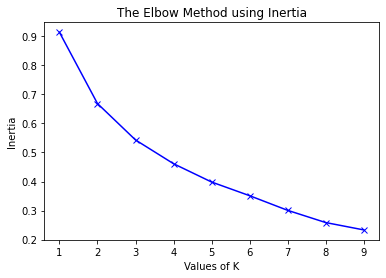

In [23]:
import matplotlib.pyplot as plt


plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

From K-Means elbow method we can conclude that an optimal number of clusters would be 4.

In [24]:
# set number of clusters
kclusters = 5

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(cairo_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([4, 2, 1, 1, 2, 2, 2, 2, 2, 1])

In [25]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

cairo_merged = cairo_df

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
cairo_merged = cairo_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

cairo_merged.head() # check the last columns!

,Neighborhood,lat,lng,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Abbassia,30.065008,31.271710,2,Café,Hotel,Lounge,Egyptian Restaurant,Historic Site,Italian Restaurant,Mosque,Middle Eastern Restaurant,Pastry Shop,Coffee Shop
1,Ain Shams,30.127778,31.329167,1,Café,Convenience Store,Dessert Shop,Italian Restaurant,Fast Food Restaurant,Gym / Fitness Center,Sandwich Place,Coffee Shop,Lebanese Restaurant,Plaza
2,Azbakeya,30.052778,31.248333,2,Hotel,Café,Lounge,Egyptian Restaurant,Italian Restaurant,Historic Site,Middle Eastern Restaurant,Theater,Pastry Shop,Pub
3,Bulaq,30.053000,31.230000,2,Hotel,Lounge,Café,Italian Restaurant,Pastry Shop,Restaurant,Seafood Restaurant,Egyptian Restaurant,Pub,Hotel Bar
4,Daher,30.074167,31.270000,2,Café,Hotel,Egyptian Restaurant,Lounge,Restaurant,Mosque,Historic Site,Pastry Shop,Coffee Shop,Bookstore


### Create a map to visualize the clustered neighborhoods

In [26]:
# create map
map_clusters = folium.Map(location=[30.0444, 31.2357], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(cairo_merged['lat'], cairo_merged['lng'], cairo_merged['Neighborhood'], cairo_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Analyze and plot Every cluster

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,El Marg,0,Café,Fast Food Restaurant,Bus Station,Garden Center,Seafood Restaurant,Falafel Restaurant,Furniture / Home Store,Mobile Phone Shop,Multiplex,Restaurant
1,Mokattam,0,Café,Historic Site,Fast Food Restaurant,Restaurant,Dessert Shop,Clothing Store,Supermarket,Juice Bar,Egyptian Restaurant,Malay Restaurant
2,El Matareya,0,Café,Supermarket,Pizza Place,Convenience Store,Plaza,Dessert Shop,Restaurant,Cosmetics Shop,Falafel Restaurant,Fast Food Restaurant


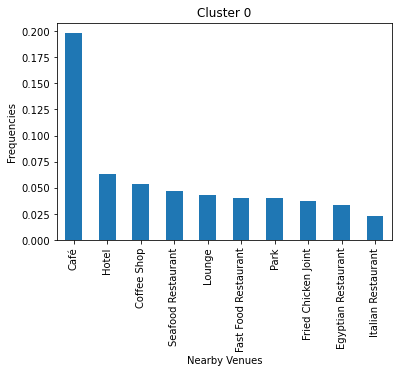

In [27]:
def cluster_and_plot(cluster_number):
    cluster = cairo_merged.loc[cairo_merged['Cluster Labels'] == cluster_number, cairo_merged.columns[[0] + list(range(3, cairo_merged.shape[1]))]]
    cairo_grouped.loc[cluster.index.tolist()].describe().loc['mean'].sort_values(ascending=False).head(10).plot(kind='bar')
    plt.xlabel('Nearby Venues')
    plt.ylabel('Frequencies')
    plt.title(f'Cluster {cluster_number}')
    return cluster.reset_index(drop=True)

cluster_and_plot(0)

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Ain Shams,1,Café,Convenience Store,Dessert Shop,Italian Restaurant,Fast Food Restaurant,Gym / Fitness Center,Sandwich Place,Coffee Shop,Lebanese Restaurant,Plaza
1,Nasr City,1,Dessert Shop,Coffee Shop,Café,Supermarket,Hotel,Multiplex,Lebanese Restaurant,Ice Cream Shop,Shopping Mall,Food Court
2,El Qobbah,1,Café,Convenience Store,Coffee Shop,Italian Restaurant,Dessert Shop,Hotel,Lebanese Restaurant,Supermarket,Sushi Restaurant,Egyptian Restaurant
3,Zeitoun,1,Café,Convenience Store,Italian Restaurant,Lebanese Restaurant,Coffee Shop,Dessert Shop,Hotel,Bookstore,Egyptian Restaurant,Falafel Restaurant
4,Heliopolis,1,Café,Convenience Store,Italian Restaurant,Hotel,Dessert Shop,Lebanese Restaurant,Sushi Restaurant,Gym / Fitness Center,Fast Food Restaurant,Falafel Restaurant
5,Maadi,1,Café,Italian Restaurant,Ice Cream Shop,Middle Eastern Restaurant,Coffee Shop,Restaurant,Supermarket,Gym / Fitness Center,Historic Site,Bakery
6,Zamalek,1,Café,Lounge,Hotel,Coffee Shop,Restaurant,Middle Eastern Restaurant,Sushi Restaurant,Italian Restaurant,Lebanese Restaurant,Bar
7,El Rehab,1,Café,Coffee Shop,Dessert Shop,Shopping Mall,Food Court,Supermarket,Lebanese Restaurant,Seafood Restaurant,Market,Mediterranean Restaurant
8,Fifth Settlement,1,Coffee Shop,Dessert Shop,Supermarket,Lebanese Restaurant,Italian Restaurant,Clothing Store,French Restaurant,Seafood Restaurant,Furniture / Home Store,Convenience Store
9,Agouza,1,Café,Hotel,Coffee Shop,Lounge,Sports Club,Seafood Restaurant,Middle Eastern Restaurant,Italian Restaurant,Restaurant,Sushi Restaurant


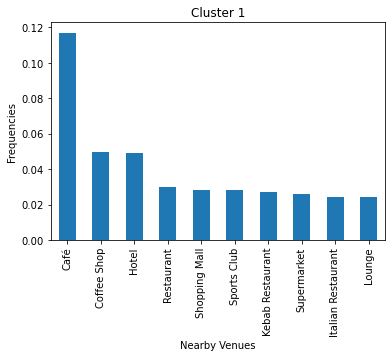

In [28]:
cluster_and_plot(1)

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Abbassia,2,Café,Hotel,Lounge,Egyptian Restaurant,Historic Site,Italian Restaurant,Mosque,Middle Eastern Restaurant,Pastry Shop,Coffee Shop
1,Azbakeya,2,Hotel,Café,Lounge,Egyptian Restaurant,Italian Restaurant,Historic Site,Middle Eastern Restaurant,Theater,Pastry Shop,Pub
2,Bulaq,2,Hotel,Lounge,Café,Italian Restaurant,Pastry Shop,Restaurant,Seafood Restaurant,Egyptian Restaurant,Pub,Hotel Bar
3,Daher,2,Café,Hotel,Egyptian Restaurant,Lounge,Restaurant,Mosque,Historic Site,Pastry Shop,Coffee Shop,Bookstore
4,Al-Darb al-Ahmar,2,Hotel,Café,Historic Site,Lounge,Egyptian Restaurant,Theater,Hotel Bar,Pastry Shop,Mosque,Kebab Restaurant
5,Manshiyat Naser,2,Historic Site,Café,Lounge,Hotel,Egyptian Restaurant,Italian Restaurant,Mosque,Juice Bar,Kebab Restaurant,Dessert Shop
6,Rhoda Island,2,Lounge,Hotel,Historic Site,Lebanese Restaurant,Hotel Bar,Café,Dessert Shop,Food Court,Gym / Fitness Center,Nightclub
7,El Sakkakini,2,Hotel,Lounge,Café,Egyptian Restaurant,Historic Site,Italian Restaurant,Coffee Shop,Middle Eastern Restaurant,Pastry Shop,Mosque
8,Shubra,2,Lounge,Café,Hotel,Restaurant,Egyptian Restaurant,Middle Eastern Restaurant,Pastry Shop,Pub,Sushi Restaurant,Italian Restaurant
9,El Sahel,2,Café,Lounge,Hotel,Egyptian Restaurant,Restaurant,Pastry Shop,Middle Eastern Restaurant,Italian Restaurant,Coffee Shop,Bar


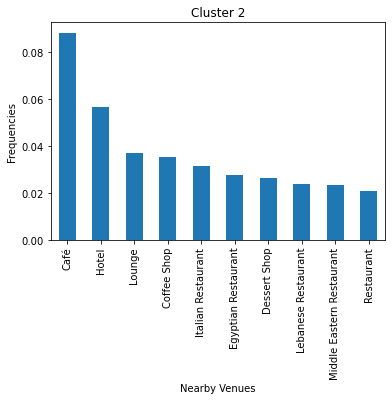

In [29]:
cluster_and_plot(2)

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Helwan,3,Café,Fried Chicken Joint,Park,Fast Food Restaurant,Coffee Shop,Seafood Restaurant,Yoga Studio,Music Venue,Mountain,Movie Theater


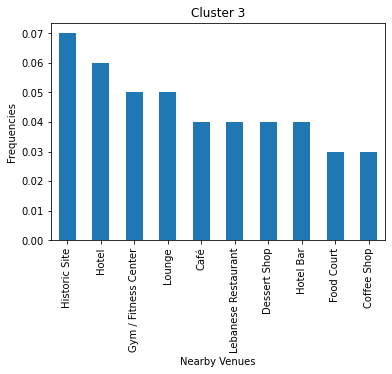

In [30]:
cluster_and_plot(3)

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Madinaty,4,Café,Coffee Shop,Kebab Restaurant,Supermarket,Plaza,Falafel Restaurant,Shopping Mall,Mobile Phone Shop,Outdoor Supply Store,Food Court
1,El Shorouk,4,Café,Shopping Mall,Falafel Restaurant,Sports Club,Kebab Restaurant,Supermarket,Coffee Shop,Bakery,Campground,Mobile Phone Shop
2,6th of October,4,Café,Fast Food Restaurant,Kebab Restaurant,Syrian Restaurant,Pizza Place,Shopping Mall,Supermarket,Coffee Shop,Fried Chicken Joint,College Cafeteria
3,Sheikh Zayed City,4,Café,Shopping Mall,Coffee Shop,Sports Club,Supermarket,Fast Food Restaurant,Food Court,Gym / Fitness Center,Clothing Store,Modern European Restaurant
4,Obour (city),4,Coffee Shop,Café,Kebab Restaurant,Go Kart Track,Supermarket,Shopping Mall,Fast Food Restaurant,Fish Market,Syrian Restaurant,Movie Theater


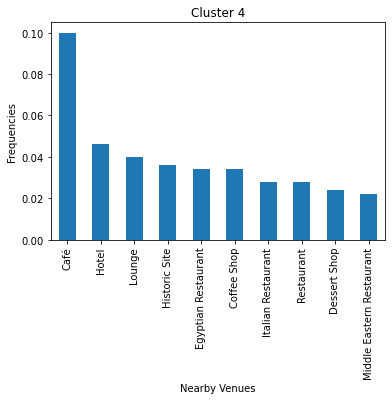

In [31]:
cluster_and_plot(4)

## Discussion

The Foursquare API have a limited venues queries in the free version. If we used the premium version we can increase the radius of search in every neighborhood which will increase the number of venues queried from the API and increase the accuracy of the model in clustering the neighborhoods correctly. 

## Conclusion

Cairo boasts the largest city population in all of Africa and the Middle East, and navigating its vast districts can be a daunting prospect for any one. I’ve picked clustered the most similar neighborhoods, from ancient quarters to affluent modern districts, to help you make the most of any business decision of choosing a place to start your business or just planning a visit to one of these neighborhoods.
While the model didn’t reach high level of accuracy in clustering these neighborhoods, its still a good start in the right direction. 
